In [1]:
import PcmPy as pcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ModelFamily.simulation as sim
import ModelFamily.examples as ex
from numpy import inf, eye, exp
import pandas as pd
import scipy.stats as ss
from variance_decomp import ModelFamilyRegress,fit_R2,reg_model,pred_R2_crossval


# Variance decomposition for regression models
The 2017 deHeer et al. paper has popularized the concept of Variance decomposition for encoding models for imaging data. In short, the idea that if you have different two different feature models (say A and B), they will explain some common aspects and some unique aspects of the data. 

The variance components can be estimated after getting the R2 values for A,B,and AB: 
Shared = A + B - AB
Unique A = A - Shared = AB - B
Unique B = B - Shared = AB - A

The concept can also be extended to three or more model components. 

As intuitive as this concept may be, it is unfortunately flawed and provides often misleading intuitions about how combinations of models work. In this notebook, I will first show some a number of basic example in the context of simple regression and fitted R2. Then I will generalize this to the context of L2-regularized regression (Ridge/Tikonov regression) and crossvalidated model evaluation. 


## Simple regression
The main problem with variance decomposition is that ignores an important aspect of coliniearity between regressors. To explain this, let's consider a simple regression model with two regressors X_A and X_B. 

#### Orthogonal regressor case

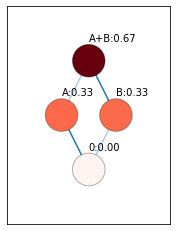

In [2]:
N=10
basis = ss.ortho_group.rvs(dim=N)
Xa = basis[:,0]
Xb = basis[:,1]
y = basis[:,0:3] @ np.array([1,1,1])
MF = ModelFamilyRegress([Xa,Xb])
T = fit_R2([y],MF)
pcm.vis.plot_tree(MF,T.R2,show_labels=True,show_value=True)



Clearly in this case, the R2 for the two components just add and the shared variance would be determined to be zero. 

#### Overlapping regressor case
The logic also seems to hold when the two regressors are related, but only as long as the aspect that they are sharing is also shared with the data. 

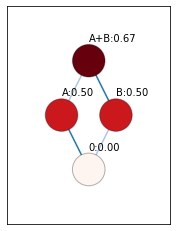

In [3]:
N=10
basis = ss.ortho_group.rvs(dim=N)
Xa = basis[:,0:4] @ np.array([1,1,0,0])
Xb = basis[:,0:4] @ np.array([0,1,1,0])
y = basis[:,0:4] @ np.array([1,1,1,1])
MF = ModelFamilyRegress([Xa,Xb])
T = fit_R2([y],MF)
pcm.vis.plot_tree(MF,T.R2,show_labels=True,show_value=True)


Here the shared variance would be estimated to be 0.33, and the unique variances for A an B would be 0.17 each.  

#### Suppression
However, when the two sets of regressors are correlated in dimensions that are not shared with the data, the entire logic of variance decomposition breaks down.
The most radical example when A does not overlap with the data at all, but shares components with B that are orthogonal to the data. 

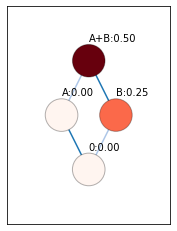

In [4]:
Xa = basis[:,0:4] @ np.array([0,1,0,0])
Xb = basis[:,0:4] @ np.array([0,1,1,0])
y = basis[:,0:4] @ np.array([0,0,1,1])
MF = ModelFamilyRegress([Xa,Xb])
T = fit_R2([y],MF)
pcm.vis.plot_tree(MF,T.R2,show_labels=True,show_value=True)

Now, the shared variance would be estimated to be negative. B would have a unique explained variance of 0.5, more than what is explains alone. 

Of course, you may say that this is an extreme case, and that in practice the combined model explains less variance than the sum of the two together. This is true, however, suppression will even occur in these cases - leading to non-intuitive results. 

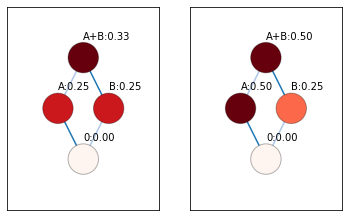

In [5]:
# Make the data, so 50% of the variance is explained by the 2nd dimension
# This dimension is also where both models overlap.
y = basis[:,0:4] @ np.array([0,1,0,1])
Xa = basis[:,0:4] @ np.array([1,1,0,0])
Xb = basis[:,0:4] @ np.array([0,1,1,0])
MF = ModelFamilyRegress([Xa,Xb])
T1 = fit_R2([y],MF)

# Now change the A basis, to be exact in the shared dimension...
Xa = basis[:,0:4] @ np.array([0,1,0,0])
Xb = basis[:,0:4] @ np.array([0,1,1,0])
MF = ModelFamilyRegress([Xa,Xb])
T2 = fit_R2([y],MF)

plt.subplot(1,2,1)
pcm.vis.plot_tree(MF,T1.R2,show_labels=True,show_value=True)
plt.subplot(1,2,2)
pcm.vis.plot_tree(MF,T2.R2,show_labels=True,show_value=True)

So even though the overlap of two models is exactly in the same direction and it is shared with the data, the shared variance would be 0.17 in the left case and 0.25 in the right case. 

I conclusion, variance is **not a quantity of the data** that can be decomposed, it is a quantity determined by the entire model family. The idea of "decomposition" provides a misleading intuition that there are fixed aspects of the data.  

## Cross-validated Tikhonov regression


Suppressive effects can also occur the tikhonov and cross-validation case. Here a unidimensional example (i.e where both the data and the regressors are 1-dimensional). 

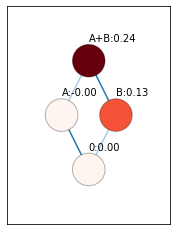

In [6]:
N=6
sig_s = 2
sig_e = 0.5
basis = ss.ortho_group.rvs(dim=N)
X = basis[:,0:4] @ np.array([0,0,1,0])
Ma = basis[:,0:4] @ np.array([0,1,0,0])
Mb = basis[:,0:4] @ np.array([0,1,1,0])
MF = ModelFamilyRegress([Ma,Mb])
T,weight = pred_R2_crossval(X,sig_s,sig_e,MF,fit_method='tikhonov')
pcm.vis.plot_tree(MF,T.predR2,show_labels=True,show_value=True)
pass


This generalizes to the multidimensional case.

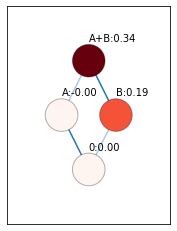

In [7]:
N=6
sig_s = 2
sig_e = 0.5
basis = ss.ortho_group.rvs(dim=N)
X = basis[:,0:6]  @ np.array([[0,0,1,0,0,0],[0,0,0,0,0,1]]).T
Ma = basis[:,0:6] @ np.array([[0,1,0,0,0,0],[0,0,0,0,1,0]]).T
Mb = basis[:,0:6] @ np.array([[0,1,1,0,0,0],[0,0,0,0,1,1]]).T
MF = ModelFamilyRegress([Ma,Mb])
T,weight = pred_R2_crossval(X,sig_s,sig_e,MF,fit_method='tikhonov')
pcm.vis.plot_tree(MF,T.predR2,show_labels=True,show_value=True)

# Difference between simple and regularized regression
While in the simple regression case, a combination of two models can be as good as the true model, this is not the case in the regularized regression case.

Text(0.5, 1.0, 'predR2')

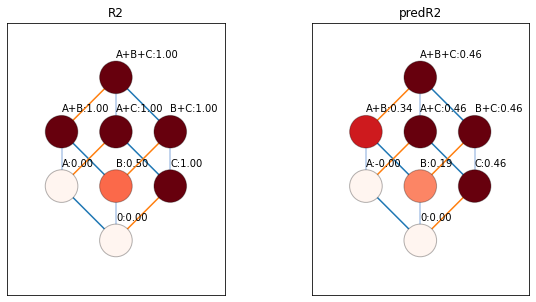

In [8]:
N=6
sig_s = 2
sig_e = 0.5
basis = eye(6) # ss.ortho_group.rvs(dim=N)

# Mc is the trie model
X = basis[:,0:6]  @ np.array([[0,0,1,0,0,0],[0,0,0,0,0,1]]).T
Ma = basis[:,0:6] @ np.array([[0,1,0,0,0,0],[0,0,0,0,1,0]]).T
Mb = basis[:,0:6] @ np.array([[0,1,1,0,0,0],[0,0,0,0,1,1]]).T
Mc = basis[:,0:6] @ np.array([[0,0,1,0,0,0],[0,0,0,0,0,1]]).T
MF = ModelFamilyRegress([Ma,Mb,Mc])
T1 = fit_R2([X],MF)
T2,weight = pred_R2_crossval(X,sig_s,sig_e,MF,fit_method='tikhonov')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
pcm.vis.plot_tree(MF,T1.R2,show_labels=True,show_value=True)
plt.title('R2')
plt.subplot(1,2,2)
pcm.vis.plot_tree(MF,T2.predR2,show_labels=True,show_value=True)
plt.title('predR2')


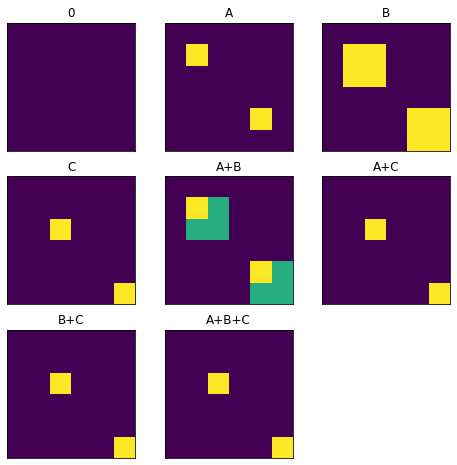

In [10]:
plt.figure(figsize=(8,8),facecolor='white')
G = MF.predict(weight)
pcm.vis.plot_Gs(G,(3,3),titles=MF.model_names)

